In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snc
from scipy.optimize import curve_fit
import datetime as dt
import calendar
from dateutil.relativedelta import relativedelta
from matplotlib.gridspec import GridSpec
plt.style.use('dark_background')

# Task 1 - analyzing and fitting gas prices

## 1. Load, clean up and visualize the data

In [25]:
data = pd.read_csv('Nat_Gas.csv')
data.head()


,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


The dataframe looks clean. Let's check the prices before we reformat the data

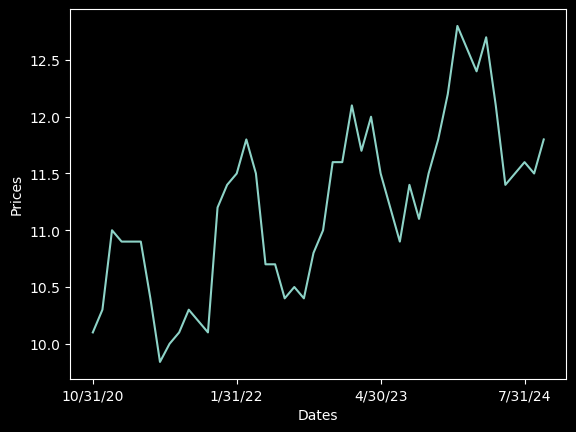

In [26]:
fig, ax = plt.subplots()
ax.plot(data['Dates'], data['Prices'])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
plt.show()


Lets make year, month columns in our dataframe (It looks nice)
Lets convert the dates into datetime format to simplify working with dates.

In [27]:
data['Dates'] = pd.to_datetime(data['Dates'])
data['year'] = data['Dates'].dt.year
data['month'] = data['Dates'].dt.month
data.head()

/var/folders/nk/mpd8dxv14bb5jnv531krgjy00000gn/T/ipykernel_5564/270562980.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates'])


,Dates,Prices,year,month
0,2020-10-31,10.1,2020,10
1,2020-11-30,10.3,2020,11
2,2020-12-31,11.0,2020,12
3,2021-01-31,10.9,2021,1
4,2021-02-28,10.9,2021,2


## 2. Make functions for data processing

### First, lets make functions to give the last days of every month in a year, format dates like we have in our 'data' dataframe and check that they work

In [28]:
# make an array of the last days of future months
def last_day_of_every_month(year):
    """given a year, it gets the last day of every month of the year

    in: year (int)
    out: dates (array of datetimes)
    """
    lastdays = []
    for month in range(1,13):
        lastdays.append(dt.date(year, month, calendar.monthrange(year, month )[1]))
    return lastdays

# make an array of the last days of the months you want to forecast
def dates_to_forecast(start_date,  end_month, end_year):
    """gives a pd dataframe with year, month and date for all months between the start and end dates

    in: start date (datetime object)
    in: end_month (int)
    in: end_year (int)
    out: df. keys: 'Dates' , 'year' , 'month'
    """
    #find how many months we need to add to our df
    end_date = dt.datetime(end_year, end_month, calendar.monthrange(end_year, end_month)[1])
    time_dif = (end_date - start_date).days
    nmonths_to_make = int(np.round(time_dif/30.4))

    new_df = {"Dates":[], "year":[], "month":[]}
    date  = start_date
    for _ in range(nmonths_to_make):
        date +=  relativedelta(days =28)
        #ensure we're actually in the last day of that month
        date = dt.date(date.year, date.month, calendar.monthrange(date.year, date.month )[1])
        new_df["Dates"].append(date)
        new_df['year'].append(date.year)
        new_df['month'].append(date.month)
    return pd.DataFrame(new_df)


In [29]:
tester_df = dates_to_forecast(data['Dates'][0], 10, 2025)
tester_df.head()

,Dates,year,month
0,2020-11-30,2020,11
1,2020-12-31,2020,12
2,2021-01-31,2021,1
3,2021-02-28,2021,2
4,2021-03-31,2021,3


### Now lets choose a model, make functions for fitting and for providing a df with features of the predicted distribution of prices.

The price data shows a steadyly increasing price with seasonal oscillations about that trend. Gas is cheap during summer and expensive during winter. A simple model for this is a linear function plus a sine.

In [30]:
def line_and_sin(x, a,b,c,d,e):
    return a + b*x + c*np.sin(2*np.pi*(d*x) + e)

def fit_gas_prices(dates, prices, cov = False):
    """Fit historical prices to the line + sin model
        in: dates (array) 
        in: prices (array) corresponding to dates
        
        out: list of best fit parameters for the line + sin model
        out: covariance matrix to evaluate fit
        """    
    popt, pcov = curve_fit(line_and_sin, np.arange(len(dates)), prices , p0 = [10, 0.05, 2,0.1,1])
    if cov == True:
        cov_matrix = plt.imshow(pcov)
        plt.colorbar(cov_matrix)
        plt.show()

    err = []
    pcov[pcov ==0] = 1e-09 
    error_matrix = np.sqrt(pcov)
    for i in range(pcov.shape[0]):
        err.append(error_matrix[i,i])


    return popt, err


def MC_price_distribution(x, params, paramerr, samples = 100):
    """
    Returns features of the distribution of predictions based on our fit to the line + sin model
    
    in: 1D array of length N - "time"
    in: list of parameters for that function
    in: list of fit errors for that function

    out: dataframe with:
        -x "months
        prices
        - Min_price_pred at x
        - Q1_pred of predicted distribution at x
        - Median_price_pred of predicted distribution
        - Q3_pred of predicted distribution 
        - Max_price_pred """
    

    #Make a dictionary to hold our predictions
    df = {"months":[], "Min_price_pred":[], "Q1_price_pred":[], "Median_price_pred":[],"Q3_price_pred":[], "Max_price_pred":[]}

    #make arrays for temporary data storage
    size = len(params)
    prediction_dist = np.zeros((x.size , samples) )
    param_dist = np.zeros((size, samples))
    
    for i in range(size):#make parameter distribution
        param_dist[i, :] = np.random.normal(loc=params[i], scale = paramerr[i], size = samples)
    for j in range(samples): #obtain predicted price distribution
        prediction_dist[:,j] = line_and_sin(x, *param_dist[:,j].tolist()) 
    
    #save distribution details and return as pd dataframe
    medianprice = np.median(prediction_dist, axis = 1)
    Q1price = np.percentile(prediction_dist, 25, axis = 1)
    Q3price = np.percentile(prediction_dist, 75, axis = 1)
    minprice = np.min(prediction_dist, axis = 1)
    maxprice = np.max(prediction_dist, axis = 1)
    df['months'] = x
    df['Min_price_pred'] = minprice
    df["Q1_price_pred"] = Q1price
    df['Median_price_pred'] = medianprice
    df['Q3_price_pred'] = Q3price
    df["Max_price_pred"] =  maxprice

    df = pd.DataFrame(df)
    return df

# 3. Fit the data and make functions to predict prices that return dataframes with the same format as 'data'

Here goes the fit.

In [31]:
popt, err = fit_gas_prices(data['Dates'], data['Prices'])

/var/folders/nk/mpd8dxv14bb5jnv531krgjy00000gn/T/ipykernel_5564/1093317140.py:20: RuntimeWarning: invalid value encountered in sqrt
  error_matrix = np.sqrt(pcov)


Now a predictor with nice formatting. 

We can either use the least squares fit to give a single value (1) or make a distribution of values based on the fit errors and provide details of the distribution (2).

In [32]:
def make_prediction_upto( month, year):
    """Gives a formatted dataframe with model prices from the start of the available data to the date provided.
    
    in: int month , int year
    out: formatted pd.DataFrame with predicted price
    """
    
    datedf = dates_to_forecast(data['Dates'][0], month, year)
    nmonths = len(datedf)
    datedf['Prices'] = line_and_sin(np.arange(nmonths), *popt)
    return datedf

def make_MC_prediction_upto( endmonth, endyear):
    """Gives a formatted dataframe with model price distribution features 
    from the start of the available data to the date provided.
    
    in: int month , int year
    out: formatted pd.DataFrame with predicted price min, Q1, median, Q3, max
    """
    datedf = dates_to_forecast(data['Dates'][0], endmonth, endyear)
    x = np.arange(len(datedf))
    results = MC_price_distribution(x,popt, err)
    results = pd.concat([datedf,results], axis = 1  )
    return results

# 4. Plot the data and predictions clearly, including the expected price variation from the model

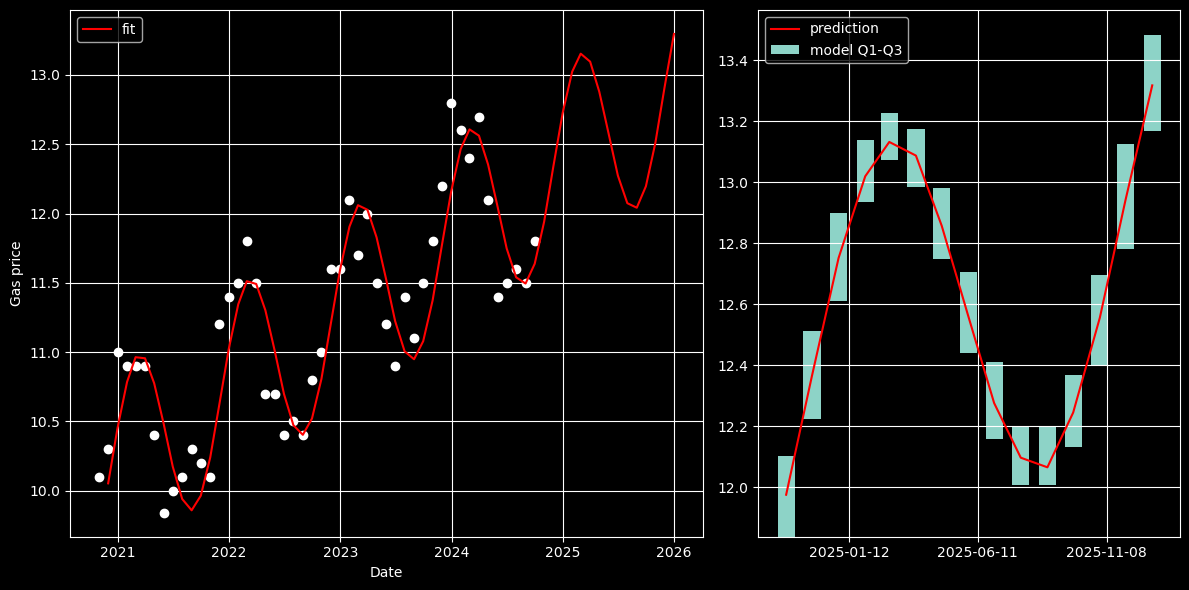

In [33]:
def plot_upto(month, year):
    """Given an end date for the forecasting, returns a plot of prices"""

    
    fig  = plt.figure(figsize = (12,6))
    grid = GridSpec(1,2, width_ratios=[1.5,1])
    figmain = fig.add_subplot(grid[0])
    figforecast = fig.add_subplot(grid[1])

    fit_price = make_prediction_upto(month,year)
    figmain.plot( fit_price['Dates'], fit_price['Prices'], color = 'r', label = 'fit')
    prediction_insights = make_MC_prediction_upto(month,year)
    forecast_only = prediction_insights[pd.to_datetime(prediction_insights['Dates']) > data['Dates'].max()]


    figforecast.plot(forecast_only['Dates'],forecast_only['Median_price_pred'], color = 'r', label = 'prediction')
    figforecast.bar(forecast_only['Dates'], bottom = forecast_only['Q1_price_pred'], height= forecast_only['Q3_price_pred'] - forecast_only['Q1_price_pred'], width=20,label = 'model Q1-Q3')


    figmain.scatter(data['Dates'], data['Prices'], color = 'white')
    figmain.set_xlabel('Date')
    figmain.set_ylabel('Gas price')
    figmain.grid()


    figforecast.xaxis.set_major_locator(plt.MaxNLocator(4))
    figforecast.grid()
    figmain.legend()
    figforecast.legend()
    
    plt.tight_layout()
    plt.show()

plot_upto(12, 2025)

# 5. In case our VP wants the expected price at the end of a given month (oct 2025), we can give them a direct answer.

In [34]:
def predict_price_for_date(month, year):
    """ returns the predicted price of natural gas at the end of the requested month """
    date = dt.datetime(year, month,calendar.monthrange(year,month)[1])
    months_from_start = (date - data['Dates'][0]).days /30.4
    print(f"The predicted price of gas for {date.date()} is {line_and_sin(months_from_start, *popt )}")
    return line_and_sin(months_from_start, *popt )



In [35]:
predict_price_for_date(10, 2025)

The predicted price of gas for 2025-10-31 is 12.934897218162604


12.934897218162604

Great! 

My simple model works.While we could use machine learning for this exercise, we don't have enough variables to think of to justify building a regressor. If we had humidity, temperature, national/global gas reserves etc. making a neural network to predict gas prices could me a good idea.

For task 2, we need a function that takes in a date instead of the month and year:

In [36]:
def PREDICT_GAS_PRICE(date):
    date = pd.to_datetime(date)
    def line_and_sin(x, a,b,c,d,e):
        return a + b*x + c*np.sin(2*np.pi*(d*x) + e)

    if date in data['Dates'].values: return data.loc[data['Dates'].values == date, 'Prices']
    else:
        months_elapsed_fromfirstdata = (date - data['Dates'].min())/30.4
        return line_and_sin(months_elapsed_fromfirstdata, *popt)

#let's save the optimal parameters to use for task 2 as a csv
fit_parameters = pd.DataFrame({'model_parameters': popt})
fit_parameters.to_csv('gas_price_model_parameters.csv')
data.to_csv('Nat_Gas_formatted.csv')
        

